In [44]:
from itertools import repeat


In [1]:
import sys
import re
import os
import numpy as np
import shutil
import matplotlib.pyplot as plt
import pandas as pd
import pandas.testing as pdt
import warnings
import logging

try:
    from pandas.core.common import SettingWithCopyWarning
except:
    from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.filterwarnings("ignore", message=".*Parameter.*")

In [2]:
pd.set_option('display.max_columns', None)  

In [36]:
def to_df(rs):

    out=pd.concat([pd.DataFrame(v).reset_index(drop=True) for k, v in rs.items()], keys = rs.keys(),axis=1) 
    out.index=rs['forcing'].index
    return out

In [37]:
def plot_range(df, var, ax,col='k'):
    Tdf=df.xs(var).T
    lower = Tdf.quantile(0.10)
    upper = Tdf.quantile(0.90)
    ax.fill_between(Tdf.columns, lower, upper, color=col, alpha=0.2,edgecolor=None)
    ax.plot(Tdf.columns, Tdf.mean(), color=col)



In [38]:
def get_results(cfg,scn=scendata,outcc=False):
    try:
        cex=CICEROSCM(scn)
        if outcc:
            cex._run({"results_as_dict": True, "carbon_cycle_outputs": outcc},pamset_udm=cfg['pamset_udm'],pamset_emiconc=cfg['pamset_emiconc'])
        else:
            cex._run({"results_as_dict": True},pamset_udm=cfg['pamset_udm'],pamset_emiconc=cfg['pamset_emiconc'])
            
        res=cex.results

    except:
        res=None
    return [cfg,res]

In [39]:
def run_parallel(cfgs,nworkers=4,scn=scendata,outcc=False):
    results=len(cfgs)*[None]
    with ProcessPoolExecutor(nworkers) as exe:
            # execute tasks concurrently and process results in order
            if type(scn)==dict:
                
                pres=list(tqdm(exe.map(get_results, cfgs,repeat(scn),repeat(outcc))))
            else:
                pres=list(tqdm(exe.map(get_results, cfgs,scn,repeat(outcc))))
            for result in pres:
                # get the corresponding index of the config
                ind=int(result[0]['Index'])
                # put it in the right element of the results vector
                results[ind]=result[1]
    return results

In [35]:
def make_ensdf(results,flds):
    resdf=[]
    for i,res in enumerate(results):
        df=to_df(res)
        test_list=df.columns.map('{0[0]}-{0[1]}'.format).tolist()
        df.columns=[sub.replace('-0', '') for sub in test_list]
        resdf.append(df[flds].unstack())
    ensdf=pd.concat(resdf,axis=1)
    ensdf.index.names = ['variable', 'year']
    ensdf.columns.names=['run_id']
    return ensdf

In [3]:
store = pd.HDFStore('data/optparam.h5')
opt = store['opt']
store.close()

In [4]:
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm

In [5]:
import concurrent

In [6]:
from ciceroscm.parallel._configdistro import _ConfigDistro
from ciceroscm.parallel.calibrator import Calibrator
from ciceroscm.parallel.distributionrun import DistributionRun


/uio/kant/div-cicero-u1/bensan/ciceroscm-1/venv/lib/python3.8/site-packages/scmdata/database/_database.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdman
/uio/kant/div-cicero-u1/bensan/ciceroscm-1/venv/lib/python3.8/site-packages/setuptools_scm/_integration/setuptools.py:31: RuntimeWarning: 
ERROR: setuptools==47.1.0 is used in combination with setuptools_scm>=8.x

Your build configuration is incomplete and previously worked by accident!
setuptools_scm requires setuptools>=61

Suggested workaround if applicable:
 - migrating from the deprecated setup_requires mechanism to pep517/518
   and using a pyproject.toml to declare build dependencies
   which are reliably pre-installed before running the build tools

  warnings.warn(


<IPython.core.display.Javascript object>

Import the model

In [7]:
sys.path.insert(0,os.path.join(os.getcwd(), '../', 'src'))
from ciceroscm import CICEROSCM

Define some input handling functions to give us example inputs

In [8]:
from ciceroscm.input_handler import read_inputfile,read_components,read_natural_emissions

Define a function to convert model output to a dataframe

set up input directories

In [9]:
test_data_dir = os.path.join(os.getcwd(), '../../', 'tests', 'test-data')

# Read in datafiles into dataframes

In [10]:
# NBVAL_IGNORE_OUTPUT
#Read gas parameters
gaspam =read_components(test_data_dir + '/gases_v1RCMIP.txt')
gaspam.head()

,EM_UNIT,CONC_UNIT,BETA,ALPHA,TAU1,TAU2,TAU3,NAT_EM,SARF_TO_ERF
GAS,,,,,,,,,
CO2,Pg_C,ppm,2.123,0.00000,150.00,0,0,0.0,1.000000
CH4,Tg,ppb,2.780,0.00000,9.60,120,160,275.0,0.877193
N2O,Tg_N,ppb,4.810,0.00000,121.00,0,0,9.5,1.000000
SO2,Tg_S,-,11.000,0.00000,0.02,0,0,0.0,1.000000
CFC-11,Gg,ppt,22.600,0.00026,45.00,0,0,0.0,1.000000


Read natural emissions

In [11]:
# NBVAL_IGNORE_OUTPUT
df_nat_ch4 =read_natural_emissions(test_data_dir + '/natemis_ch4.txt','CH4')
df_nat_n2o =read_natural_emissions(test_data_dir + '/natemis_n2o.txt','N2O')
df_nat_ch4[:]=df_nat_ch4.iloc[0]
df_nat_n2o[:]=df_nat_n2o.iloc[0]

df_nat_ch4.head()


,CH4
year,
1750,269.4273
1751,269.4273
1752,269.4273
1753,269.4273
1754,269.4273


Read forcing

In [12]:
df_flat_conc =read_inputfile(test_data_dir + '/ssp245_conc_RCMIP.txt')
df_flat_conc =read_inputfile(test_data_dir + '/ssp245_conc_RCMIP.txt')
df_flat_conc[:]=df_flat_conc.iloc[101]


In [13]:
df_1pct_conc=df_flat_conc.copy()
nt=len(df_1pct_conc)
df_1pct_conc['CO2'][:]=278

df_1pct_conc['CO2'][50:]=278*(1.01**(np.arange(0,nt-50)))



(1700.0, 2000.0)

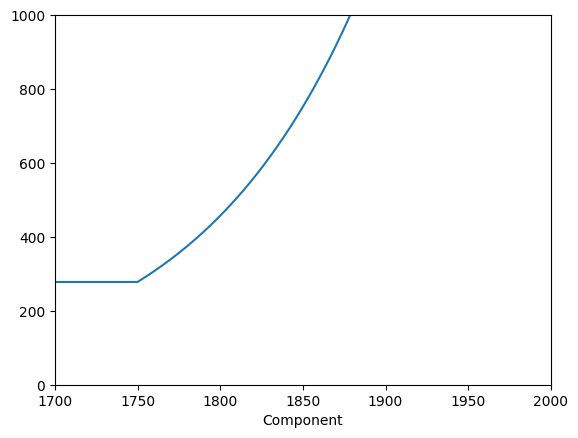

In [14]:
df_1pct_conc['CO2'].plot()
plt.ylim([0,1000])
plt.xlim([1700,2000])


In [49]:
emi_input =read_inputfile(test_data_dir + '/ssp245_em_RCMIP.txt')
emi_input.rename(columns={"CO2": "CO2_FF", "CO2.1": "CO2_AFOLU"}, inplace=True)
emi_input[:]=emi_input.iloc[0]*0

emi_input['CO2_FF'][100:]=10

In [50]:
emi_input_zec=emi_input.copy()
emi_input_zec['CO2_FF'][200:]=0


In [17]:
emi_input_cdr=emi_input.copy()
emi_input_cdr['CO2_FF'][200:300]=np.arange(10,-10,-.2)
emi_input_cdr['CO2_FF'][300:400]=-10
emi_input_cdr['CO2_FF'][400:]=0



# Set up model run with defined input variables

In [18]:
scendata_1pct={
            "gaspam_data": gaspam,
            "emstart": 2500,  
            "conc_run":True,
            "nystart": 1750,
            "nyend": 2100,
            "concentrations_data": df_1pct_conc,
            "emissions_data": emi_input,
            "nat_ch4_data": df_nat_ch4,
            "nat_n2o_data": df_nat_n2o,
            "idtm":24,
        }

In [268]:
scendata={
            "gaspam_data": gaspam,
            "emstart": 2500,  
            "conc_run":False,
            "nystart": 1750,
            "nyend": 2200,
            "concentrations_data": df_flat_conc,
            "emissions_data": emi_input,
            "nat_ch4_data": df_nat_ch4,
            "nat_n2o_data": df_nat_n2o,
            "idtm":24,
        }

In [269]:

scendata_zec=scendata.copy()
scendata_zec["emissions_data"]=emi_input_zec



In [270]:
scendata_cdr=scendata.copy()
scendata_cdr["emissions_data"]=emi_input_cdr

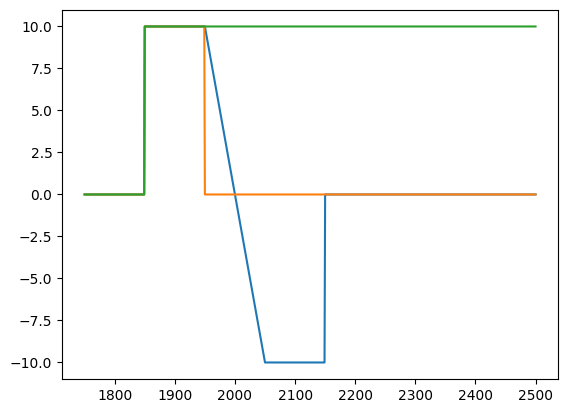

In [271]:
plt.plot(scendata_cdr["emissions_data"]['CO2_FF'])
plt.plot(scendata_zec["emissions_data"]['CO2_FF'])

plt.plot(scendata["emissions_data"]['CO2_FF'])

In [22]:
    calibdata = pd.DataFrame(
        data={
            "Variable Name": [
                "Heat Content|Ocean",
                "Surface Air Ocean Blended Temperature Change",
            ],
            "Yearstart_norm": [1971, 1961],
            "Yearend_norm": [1971, 1990],
            "Yearstart_change": [2018, 2000],
            "Yearend_change": [2018, 2019],
            "Central Value": [320.69251537323, 0.5372],
            "sigma": [17.020342912051203, 0.039028311931729676],
        })

In [23]:
testconfig = _ConfigDistro( )

distro_array not 2 dimensional, disregarding


In [24]:

# NBVAL_IGNORE_OUTPUT
scen = 'test'



In [272]:
distrorun1 = DistributionRun(testconfig, numvalues=len(opt))
output_vars = ["Heat Uptake", "Surface Air Temperature Change"]


[ 5.          0.06        0.161       0.55        0.          0.53908356
 25.          0.4        -0.55       -1.5         0.1        -0.1
  0.11       25.        ]
[ 2.50000000e+01  8.00000000e-01  5.69000000e-01  2.55000000e+00
  7.00000000e+00  1.34770889e+00  1.25000000e+02  6.00000000e-01
 -2.00000000e-01 -5.00000000e-01  2.00000000e-01 -6.00000000e-02
  4.65000000e-01  1.25000000e+02]


overwrite parameter values with opt

In [273]:
for j,c in enumerate(distrorun1.cfgs):
    for typ in ['pamset_udm','pamset_emiconc']:
        pkys=list(c[typ].keys())
        ins=list(set(opt.iloc[j].keys()).intersection(pkys))
        for i in ins:   
            c[typ][i]=opt.iloc[j][i]
    c['pamset_emiconc']['qo3']=0


In [274]:
results=run_parallel(distrorun1.cfgs,nworkers=100,scn=scendata,outcc=False)
results_cdr=run_parallel(distrorun1.cfgs,nworkers=100,scn=scendata_cdr,outcc=False)
results_zec=run_parallel(distrorun1.cfgs,nworkers=100,scn=scendata_zec,outcc=False)


1000it [04:32,  3.66it/s]
1000it [04:38,  3.59it/s]
1000it [04:41,  3.55it/s]


In [275]:
flds=['dT_glob','OHC700','concentrations-CO2','RIB_glob']

In [276]:
df1=make_ensdf(results,flds)
df1_zec=make_ensdf(results_zec,flds)
df1_cdr=make_ensdf(results_cdr,flds)


In [137]:
import xarray as xr

(-1.0, 5.0)

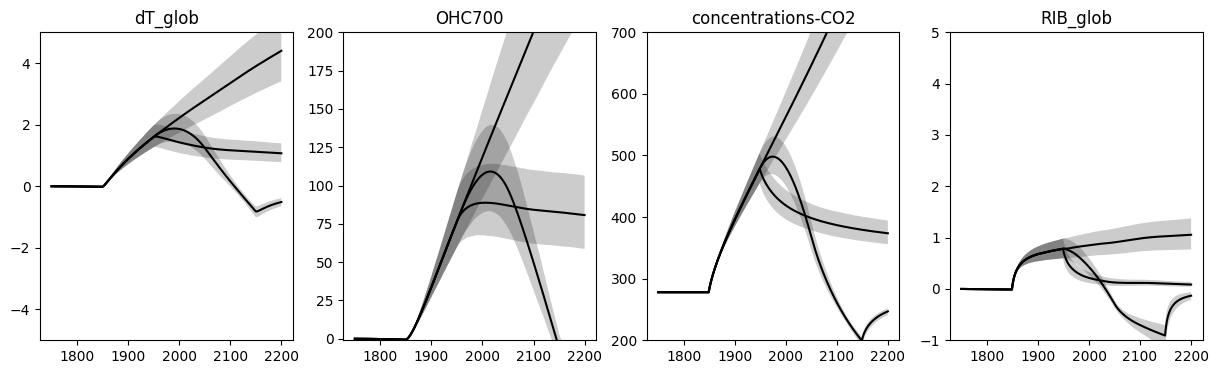

In [277]:

fig, ax = plt.subplots( 1,len(flds) ,figsize=(15, 4))

ax=ax.flatten()
for i,f in enumerate(flds):
    plot_range(df1, f, ax[i])
    plot_range(df1_zec, f, ax[i])
    plot_range(df1_cdr, f, ax[i])
    
    
    ax[i].set_title(f)
ax[0].set_ylim([-5,5])
ax[1].set_ylim([-1,200])
ax[2].set_ylim([200,700])
ax[3].set_ylim([-1,5])



In [278]:
results_1pct=run_parallel(distrorun1.cfgs,nworkers=100,scn=scendata_1pct,outcc=True)


0it [00:00, ?it/s]
/uio/kant/div-cicero-u1/bensan/ciceroscm-1/src/ciceroscm/carbon_cycle_mod.py:309: RuntimeWarning: invalid value encountered in log
  60 * self.pamset["beta_f"] * np.log(self.co2_hold["xCO2"] / 278.0)
/uio/kant/div-cicero-u1/bensan/ciceroscm-1/src/ciceroscm/carbon_cycle_mod.py:309: RuntimeWarning: invalid value encountered in log
  60 * self.pamset["beta_f"] * np.log(self.co2_hold["xCO2"] / 278.0)
/uio/kant/div-cicero-u1/bensan/ciceroscm-1/src/ciceroscm/carbon_cycle_mod.py:309: RuntimeWarning: invalid value encountered in log
  60 * self.pamset["beta_f"] * np.log(self.co2_hold["xCO2"] / 278.0)
/uio/kant/div-cicero-u1/bensan/ciceroscm-1/src/ciceroscm/carbon_cycle_mod.py:309: RuntimeWarning: invalid value encountered in log
  60 * self.pamset["beta_f"] * np.log(self.co2_hold["xCO2"] / 278.0)
/uio/kant/div-cicero-u1/bensan/ciceroscm-1/src/ciceroscm/carbon_cycle_mod.py:309: RuntimeWarning: invalid value encountered in log
  60 * self.pamset["beta_f"] * np.log(self.co2_hol

KeyboardInterrupt: 

In [115]:
tcremat=np.ones(len(results_1pct))
t1000mat=[]
emis1pc_zec=[]
emis1pc=[]

scendata_e1pct=[]
scendata_e1pct_zec=[]

for i,r in enumerate(results_1pct):
    tmp=r['carbon cycle']['Emissions'].fillna(0).clip(upper=50).clip(lower=0).copy()
    
    t1000=np.argmax(tmp.cumsum()>1000)
    tcremat[i]=r['dT_glob'][t1000]
    emis1pc.append(scendata_1pct['emissions_data'].copy())
    
    emis1pc[i]['CO2_FF']=tmp
    emis1pc[i]['CO2_FF'][250:]=0
    emis1pc_zec.append(scendata_1pct['emissions_data'].copy())
    emis1pc_zec[i]['CO2_FF']=tmp
    emis1pc_zec[i]['CO2_FF'][t1000:]=0 
    t1000mat.append(t1000)
    scendata_e1pct.append(scendata.copy())
    scendata_e1pct[i]["emissions_data"]=emis1pc[i]
    scendata_e1pct_zec.append(scendata.copy())
    scendata_e1pct_zec[i]["emissions_data"]=emis1pc_zec[i]



In [116]:
results_e1pct=run_parallel(distrorun1.cfgs,nworkers=100,scn=scendata_e1pct,outcc=False)
results_e1pct_zec=run_parallel(distrorun1.cfgs,nworkers=100,scn=scendata_e1pct_zec,outcc=False)




0it [00:00, ?it/s]/uio/kant/div-cicero-u1/bensan/ciceroscm-1/src/ciceroscm/carbon_cycle_mod.py:309: RuntimeWarning: invalid value encountered in log
  60 * self.pamset["beta_f"] * np.log(self.co2_hold["xCO2"] / 278.0)
/uio/kant/div-cicero-u1/bensan/ciceroscm-1/src/ciceroscm/carbon_cycle_mod.py:309: RuntimeWarning: invalid value encountered in log
  60 * self.pamset["beta_f"] * np.log(self.co2_hold["xCO2"] / 278.0)
3it [00:02,  1.46it/s]/uio/kant/div-cicero-u1/bensan/ciceroscm-1/src/ciceroscm/carbon_cycle_mod.py:309: RuntimeWarning: invalid value encountered in log
  60 * self.pamset["beta_f"] * np.log(self.co2_hold["xCO2"] / 278.0)
186it [00:05, 67.03it/s]/uio/kant/div-cicero-u1/bensan/ciceroscm-1/src/ciceroscm/carbon_cycle_mod.py:309: RuntimeWarning: invalid value encountered in log
  60 * self.pamset["beta_f"] * np.log(self.co2_hold["xCO2"] / 278.0)
295it [00:07, 71.63it/s]/uio/kant/div-cicero-u1/bensan/ciceroscm-1/src/ciceroscm/carbon_cycle_mod.py:309: RuntimeWarning: invalid value 

In [121]:
isgd=np.where([r!=None for r in results_e1pct])[0].astype(int)

In [279]:
tcremat_e=[]
zec50mat=[]

zec100mat=[]

for i,zf in enumerate(results_e1pct_zec):
    tcremat_e.append(results_e1pct_zec[i]['dT_glob'][t1000mat[i]])
    try:
        zec50mat.append(results_e1pct_zec[i]['dT_glob'][t1000mat[i+50]]-tcremat_e[i])
    except:
        zec50mat.append(np.NaN)
    try:
        zec100mat.append(results_e1pct_zec[i]['dT_glob'][t1000mat[i+100]]-tcremat_e[i])
    except:
        zec100mat.append(np.NaN)
zec50mat=np.array(zec50mat)
tcremat_e=np.array(tcremat_e)

zec100mat=np.array(zec100mat)

In [280]:
zec50mat[np.abs(tcremat-tcremat_e)>0.1]=np.NaN
zec100mat[np.abs(tcremat-tcremat_e)>0.1]=np.NaN
tcremat_e[np.abs(tcremat-tcremat_e)>0.1]=np.NaN

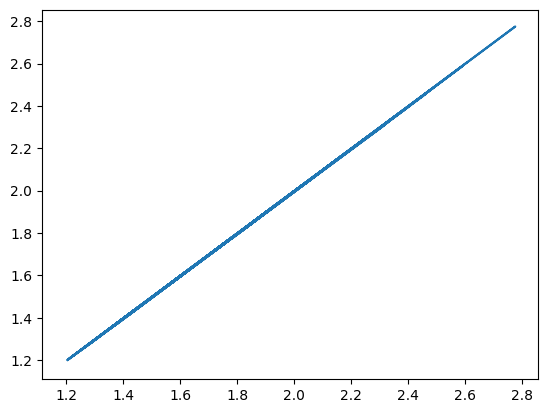

In [281]:
plt.plot(tcremat,tcremat_e)

In [282]:
xdf=xr.Dataset()
xdf_zec=xr.Dataset()
xdf_cdr=xr.Dataset()


for f in flds:
    xdf[f]=xr.DataArray(df1.loc[f].T.to_numpy(), coords={'config': df1.columns.values,'time': df1.loc[flds[0]].index.values}, 
                    dims=["config", "time"])    
    xdf_zec[f]=xr.DataArray(df1_zec.loc[f].T.to_numpy(), coords={'config': df1.columns.values,'time': df1.loc[flds[0]].index.values}, 
                    dims=["config", "time"])
    xdf_cdr[f]=xr.DataArray(df1_cdr.loc[f].T.to_numpy(), coords={'config': df1.columns.values,'time': df1.loc[flds[0]].index.values}, 
                    dims=["config", "time"])
    
    
f10_cic=xr.concat([xdf,xdf_zec,xdf_cdr], 'scenario')
f10_cic['scenario']=['esm-flat10','esm-flat10_zec','esm-flat10_cdr']

xtcre=xr.DataArray(tcremat,coords={'config': df1.columns.values})
f10_cic['tcre']=xtcre
xzec50=xr.DataArray(zec50mat,coords={'config': df1.columns.values})
f10_cic['zec50']=xzec50
xzec100=xr.DataArray(zec50mat,coords={'config': df1.columns.values})
f10_cic['zec100']=xzec100
    

In [283]:
f10_cic.to_netcdf('data/cic_flat10.nc')

In [284]:
f10_cic

<xarray.Dataset>
Dimensions:             (config: 1000, time: 451, scenario: 3)
Coordinates:
  * config              (config) int64 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
  * time                (time) int64 1750 1751 1752 1753 ... 2197 2198 2199 2200
  * scenario            (scenario) <U14 'esm-flat10' ... 'esm-flat10_cdr'
Data variables:
    dT_glob             (scenario, config, time) float64 0.0 ... -0.3942
    OHC700              (scenario, config, time) float64 0.0 ... -13.54
    concentrations-CO2  (scenario, config, time) float64 278.0 278.0 ... 247.3
    RIB_glob            (scenario, config, time) float64 0.0 ... -0.121
    tcre                (config) float64 1.633 1.747 1.577 ... 1.204 1.72 1.482
    zec50               (config) float64 -0.8676 -0.1884 -0.08351 ... nan nan
    zec100              (config) float64 -0.8676 -0.1884 -0.08351 ... nan nan